# select particle and extract trajectory

(1) This script searches particular trajectory that passes through a certain region (lon,lat,depth) in a specific month (year, month)

(2) Saves the extracted trajectories in a small netCDF file in scratch disk

(3) Performs initial data quality check (based on vertical displacement for now)

(4) Makes plots of trajectories



In [1]:
import numpy as np
import xarray as xr
import glob
import datetime
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from multiprocessing import Pool

In [2]:
# The data source is here (do not change)
projdir='/global/cfs/cdirs/m3920/dataset/MPAS-O/takaito/'

In [3]:
# Define temporary folders: please change 'takaito' to your username
tempdir='/global/cscratch1/sd/takaito/temp'
outdir='/global/cscratch1/sd/takaito/particle_results'
! mkdir -p /global/cscratch1/sd/takaito/particle_results
! mkdir -p /global/cscratch1/sd/takaito/temp

### define some helper functions

select_particle_XYZT: This function identifies particle trajectory that passes (lon,lat,depth) position within (Rxy) lon-lat degree radius within the depth range of (Rz) at (refyear, refmon). It returns particle ID (partid) and indices (ind)

extract_trajectory_yearly(year): This function extracts (lon,lat,depth) position of certain particle with (ind) indices and save them as netCDF file for the model year (year)

In [4]:
def select_particle_XYZT(lon,lat,dep,Rxy,Rz,refyear,refmon):
    dx=xr.open_dataset(projdir+'lonParticle-'+str(refyear)+'-'+str(refmon)+'.nc')
    dy=xr.open_dataset(projdir+'latParticle-'+str(refyear)+'-'+str(refmon)+'.nc')
    dz=xr.open_dataset(projdir+'zLevelParticle-'+str(refyear)+'-'+str(refmon)+'.nc')
    # find 
    indxy = (((dx['lonParticle'][0,:]-lon)**2 + (dy['latParticle'][0,:]-lat)**2)) <= Rxy**2
    indz= (dz['zLevelParticle'][0,:]-dep)**2 <= Rz**2
    ind = (indxy==True) & (indz==True)
    partid=dx['particleID'][ind]
    return partid,ind

def extract_trajectory(ind,year,mon):
    dx=xr.open_dataset(projdir+'lonParticle-'+str(year)+'-'+str(mon)+'.nc')
    dy=xr.open_dataset(projdir+'latParticle-'+str(year)+'-'+str(mon)+'.nc')
    dz=xr.open_dataset(projdir+'zLevelParticle-'+str(year)+'-'+str(mon)+'.nc')
    dx0=dx.where(ind)
    dy0=dy.where(ind)
    dz0=dz.where(ind)
    x=dx0['lonParticle'].dropna(dim='particleID')
    y=dy0['latParticle'].dropna(dim='particleID')
    z=dz0['zLevelParticle'].dropna(dim='particleID')
    return x,y,z

def extract_trajectory_yearly(year):
    dx=xr.open_mfdataset(projdir+'lonParticle-'+str(year)+'-*.nc')
    dy=xr.open_mfdataset(projdir+'latParticle-'+str(year)+'-*.nc')
    dz=xr.open_mfdataset(projdir+'zLevelParticle-'+str(year)+'-*.nc')
    dx0=dx.where(ind)
    dy0=dy.where(ind)
    dz0=dz.where(ind)
    x=dx0['lonParticle'].dropna(dim='particleID')
    y=dy0['latParticle'].dropna(dim='particleID')
    z=dz0['zLevelParticle'].dropna(dim='particleID')
    ds=xr.merge([x,y,z])
    ds.to_netcdf(tempdir+'/xyz-'+str(year)+'.nc')

### Now execute the functions and select particular trajectories

In [5]:
%%time
loclab='StnP' # Give it a name to label output netCDF and PDF
year='1992'   # Choose between 1981 and 1992
mon='12'      # Choose between 1 and 12
long=360-145  # Target longitude
lati=50       # Target latitude
depc=50       # Target depth range is (depc-ddep) < z < (depc+ddep)
ddep=50
Rxy= 3.       # Target radius (in degree lon-lat)

! rm /global/cscratch1/sd/takaito/temp/*.nc

# Select trajectory 
partid,ind=select_particle_XYZT(long,lati,-depc,Rxy,ddep,year,mon) # StnP

#partid,ind=select_particle_XYZT(360-62,-59,-50,3,50,year,mon) # Drake Passage
#partid,ind=select_particle_XYZT(360-85,-5,-50,5,50,year,mon) # Nino1.2
#partid,ind=select_particle_XYZT(360-105,10,-depc,5,ddep,year,mon) # ETNP OMZ
#partid,ind=select_particle_XYZT(360-155,22.5,-depc,5,ddep,year,mon) # HOT

# Extract trajectory
if __name__ == '__main__':
    with Pool(12) as p:
        p.map(extract_trajectory_yearly, range(1981,1993))

# Save results
dss=xr.open_mfdataset(tempdir+'/xyz-*')
dss.to_netcdf(outdir+'/'+loclab+'_'+str(depc-ddep)+'-'+str(depc+ddep)+'m_'+year+'-'+mon+'.nc')

CPU times: user 422 ms, sys: 327 ms, total: 749 ms
Wall time: 16.8 s


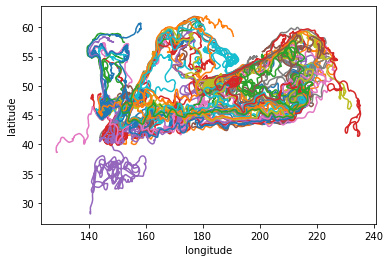

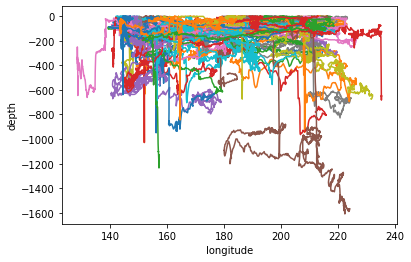

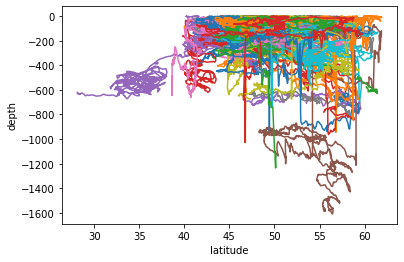

In [6]:
# Make a simple plot (without QC)
dss=xr.open_dataset(outdir+'/'+loclab+'_'+str(depc-ddep)+'-'+str(depc+ddep)+'m_'+year+'-'+mon+'.nc')
x=dss['lonParticle']
y=dss['latParticle']
z=dss['zLevelParticle']
#
plt.plot(x,y)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()
plt.plot(x,z)
plt.xlabel('longitude')
plt.ylabel('depth')
plt.show()
plt.plot(y,z)
plt.xlabel('latitude')
plt.ylabel('depth')
plt.show()

### data quality control. 

Check bad trajectory and flag them

In [7]:
# For now, I use criteria to flat sudden vertical shift of more than (dzcrit)
dzcrit = 100.
#
qcflag=[]
for pid in dss['particleID']:
    ztmp=z.sel(particleID=pid)
    dztmp=np.diff(ztmp)
    dzmax=np.max(dztmp)
    dzmin=-np.min(dztmp)
    dzabs=np.max([dzmax,dzmin])
    if dzabs >= dzcrit:  
        print('flagged, max|dz| = '+str(dzabs)+': particleID='+str(int(pid)))
        qcflag.append(9) # bad data, large vertical jump
    else:
        qcflag.append(0) # good data

# set up a data array called QC
QC=xr.DataArray(data=qcflag,coords={'particleID':dss['particleID']})

flagged, max|dz| = 164.6095: particleID=58329
flagged, max|dz| = 880.25604: particleID=63983
flagged, max|dz| = 881.77136: particleID=76583
flagged, max|dz| = 263.03735: particleID=86652
flagged, max|dz| = 254.31937: particleID=87044
flagged, max|dz| = 326.6015: particleID=105852
flagged, max|dz| = 563.23596: particleID=153789
flagged, max|dz| = 778.66327: particleID=155403
flagged, max|dz| = 145.42972: particleID=177785
flagged, max|dz| = 496.9942: particleID=225007
flagged, max|dz| = 107.06528: particleID=244736
flagged, max|dz| = 152.78479: particleID=467793
flagged, max|dz| = 520.5777: particleID=527006
flagged, max|dz| = 461.16443: particleID=723565
flagged, max|dz| = 417.2154: particleID=774795
flagged, max|dz| = 709.5682: particleID=827095
flagged, max|dz| = 298.7553: particleID=873810
flagged, max|dz| = 266.29907: particleID=957635


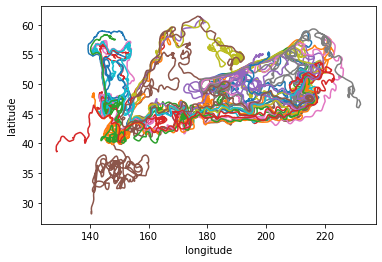

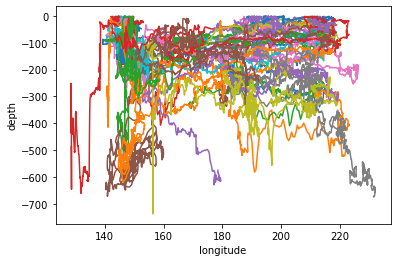

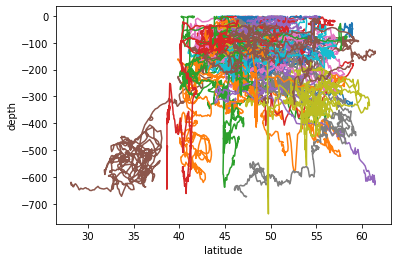

In [8]:
# Re-plot the data after QC
ind=(QC==0)
x=dss['lonParticle'][:,ind]
y=dss['latParticle'][:,ind]
z=dss['zLevelParticle'][:,ind]
dss1=xr.merge((x,y,z))
dss1.to_netcdf(outdir+'/'+loclab+'_'+str(depc-ddep)+'-'+str(depc+ddep)+'m_'+year+'-'+mon+'_QC.nc')
plt.plot(x,y)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()
plt.plot(x,z)
plt.xlabel('longitude')
plt.ylabel('depth')
plt.show()
plt.plot(y,z)
plt.xlabel('latitude')
plt.ylabel('depth')
plt.show()

/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(

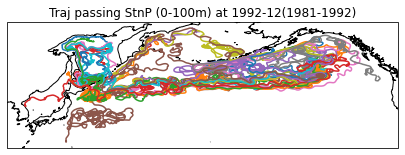

In [9]:
dss1 = xr.open_dataset(outdir+'/'+loclab+'_'+str(depc-ddep)+'-'+str(depc+ddep)+'m_'+year+'-'+mon+'_QC.nc')
x=dss1['lonParticle']
y=dss1['latParticle']
z=dss1['zLevelParticle']
#
# make it nicer
fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
ax.coastlines()
# ax.gridlines(linestyle='--')
cf=ax.plot(x,y, transform=ccrs.PlateCarree())
#fig.colorbar(cf, ax=ax,shrink=0.7, label='Temperature ($^\circ$C)')
ax.set_title('Traj passing '+loclab+' ('+str(depc-ddep)+'-'+str(depc+ddep)+'m) at '+year+'-'+mon+'(1981-1992)')
#! mkdir fig
fn='Fig_traj_'+loclab+'_'+year+'-'+mon
#plt.savefig(outdir+'/'+fn+'.pdf',bbox_inches="tight",dpi=300)
#plt.savefig(outdir+'/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()